In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm_notebook
# import seaborn as sns

In [2]:
data = pd.read_json('../input/train.json')
test = pd.read_json('../input/test.json')

In [3]:
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",dfd5f913,43.9239,0
1,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",e25388fd,38.1562,0
2,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",58b2aaa0,45.2859,1
3,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",4cfc3a18,43.8306,0
4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",271f93f4,35.6256,0


In [4]:
data['band_1'] = data['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
data['band_2'] = data['band_2'].apply(lambda x: np.array(x).reshape(75, 75))
test['band_1'] = test['band_1'].apply(lambda x: np.array(x).reshape(75, 75))
test['band_2'] = test['band_2'].apply(lambda x: np.array(x).reshape(75, 75))

data['inc_angle'] = pd.to_numeric(data['inc_angle'], errors='coerce')
test['inc_angle'] = pd.to_numeric(test['inc_angle'], errors='coerce')

train = data.sample(frac=0.8)
val = data[~data.isin(train)].dropna()

In [5]:
data.head()

,band_1,band_2,id,inc_angle,is_iceberg
0,"[[-27.878361, -27.15416, -28.668615, -29.53797...","[[-27.154118, -29.537888, -31.0306, -32.190483...",dfd5f913,43.9239,0
1,"[[-12.242375, -14.920305, -14.920363, -12.6663...","[[-31.506321, -27.984554, -26.645678, -23.7676...",e25388fd,38.1562,0
2,"[[-24.603676, -24.603714, -24.871029, -23.1527...","[[-24.870956, -24.092632, -20.653963, -19.4110...",58b2aaa0,45.2859,1
3,"[[-22.454607, -23.082819, -23.998013, -23.9980...","[[-27.889421, -27.519794, -27.165262, -29.1035...",4cfc3a18,43.8306,0
4,"[[-26.006956, -23.164886, -23.164886, -26.8911...","[[-27.206915, -30.259186, -30.259186, -23.1649...",271f93f4,35.6256,0


In [6]:
def plot_sample(df, idx):
    c = ('Not Hotdog', 'Hotdog')
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    ax1.imshow(df['band_1'].iloc[idx])
    ax2.imshow(df['band_2'].iloc[idx])
    ax3.hist(df['band_1'].iloc[idx].ravel(), bins=256, fc='k', ec='k');
    ax4.hist(df['band_2'].iloc[idx].ravel(), bins=256, fc='k', ec='k');
    f.set_figheight(10)
    f.set_figwidth(10)
    plt.suptitle(c[df['is_iceberg'].iloc[idx]])
    plt.show()

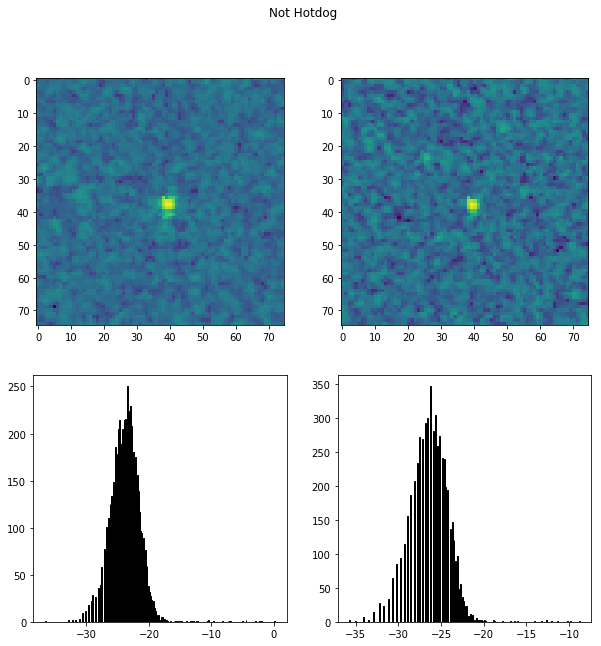

In [7]:
plot_sample(train, 299)

#### Concat Bands into (N, 2, 75, 75) images

In [8]:
band_1_tr = np.concatenate([im for im in train['band_1']]).reshape(-1, 75, 75)
band_2_tr = np.concatenate([im for im in train['band_2']]).reshape(-1, 75, 75)
full_img_tr = np.stack([band_1_tr, band_2_tr], axis=1)

band_1_val = np.concatenate([im for im in val['band_1']]).reshape(-1, 75, 75)
band_2_val = np.concatenate([im for im in val['band_2']]).reshape(-1, 75, 75)
full_img_val = np.stack([band_1_val, band_2_val], axis=1)

band_1_test = np.concatenate([im for im in test['band_1']]).reshape(-1, 75, 75)
band_2_test = np.concatenate([im for im in test['band_2']]).reshape(-1, 75, 75)
full_img_test = np.stack([band_1_test, band_2_test], axis=1)

#### dataloader

In [44]:
train_imgs = torch.from_numpy(full_img_tr).float()
train_targets = torch.from_numpy(train['is_iceberg'].values).long()
# train_targets = torch.LongTensor(train_targets)
train_dataset = TensorDataset(train_imgs, train_targets)

val_imgs = torch.from_numpy(full_img_val).float()
val_targets = torch.from_numpy(val['is_iceberg'].values).long()
val_dataset = TensorDataset(val_imgs, val_targets)


test_imgs  = torch.from_numpy(full_img_test).float()

In [45]:
train_dataset[0]

(
 (0 ,.,.) = 
  -28.5108 -19.9422 -19.2357  ...  -23.7671 -25.8204 -27.0634
  -23.1035 -22.8943 -20.8738  ...  -23.1071 -26.1149 -28.9185
  -20.0907 -24.4779 -23.7637  ...  -26.4196 -26.1149 -28.1283
             ...               ⋱              ...            
  -22.4909 -23.3188 -24.9897  ...  -21.2121 -23.9995 -22.4945
  -22.6906 -23.5387 -23.3188  ...  -21.2121 -23.9995 -25.5364
  -24.9897 -22.6907 -21.9181  ...  -18.9726 -21.9216 -25.2606
 
 (1 ,.,.) = 
  -27.7550 -22.4902 -22.6900  ...  -21.7380 -23.1072 -27.0634
  -31.8374 -25.5320 -25.2563  ...  -23.7671 -24.2368 -24.2368
  -29.7842 -31.2769 -28.9149  ...  -28.5143 -24.2368 -25.2599
             ...               ⋱              ...            
  -25.8175 -25.8176 -25.5328  ...  -25.8211 -27.7593 -28.9192
  -26.7327 -25.8176 -25.5328  ...  -25.8211 -24.9933 -25.5364
  -26.7327 -25.5328 -25.2571  ...  -24.2374 -22.6942 -23.5423
 [torch.FloatTensor of size 2x75x75], 0)

In [46]:
from skorch.net import NeuralNetClassifier

In [47]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.batch = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.drp = nn.Dropout(0.5)

    def forward(self, x):
        x = self.batch(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drp(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drp(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
#         x = self.drp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [48]:
net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
)

In [49]:
train_dataset.data_tensor


( 0  , 0  ,.,.) = 
 -2.8511e+01 -1.9942e+01 -1.9236e+01  ...  -2.3767e+01 -2.5820e+01 -2.7063e+01
 -2.3104e+01 -2.2894e+01 -2.0874e+01  ...  -2.3107e+01 -2.6115e+01 -2.8919e+01
 -2.0091e+01 -2.4478e+01 -2.3764e+01  ...  -2.6420e+01 -2.6115e+01 -2.8128e+01
                 ...                   ⋱                   ...                
 -2.2491e+01 -2.3319e+01 -2.4990e+01  ...  -2.1212e+01 -2.4000e+01 -2.2495e+01
 -2.2691e+01 -2.3539e+01 -2.3319e+01  ...  -2.1212e+01 -2.4000e+01 -2.5536e+01
 -2.4990e+01 -2.2691e+01 -2.1918e+01  ...  -1.8973e+01 -2.1922e+01 -2.5261e+01

( 0  , 1  ,.,.) = 
 -2.7755e+01 -2.2490e+01 -2.2690e+01  ...  -2.1738e+01 -2.3107e+01 -2.7063e+01
 -3.1837e+01 -2.5532e+01 -2.5256e+01  ...  -2.3767e+01 -2.4237e+01 -2.4237e+01
 -2.9784e+01 -3.1277e+01 -2.8915e+01  ...  -2.8514e+01 -2.4237e+01 -2.5260e+01
                 ...                   ⋱                   ...                
 -2.5818e+01 -2.5818e+01 -2.5533e+01  ...  -2.5821e+01 -2.7759e+01 -2.8919e+01
 -2.6733e+01

In [41]:
full_img_tr.shape

(1283, 2, 75, 75)

In [42]:
train['is_iceberg'].shape

(1283,)

In [50]:
# net.fit(train_dataset.data_tensor.float(), train_dataset.target_tensor.int())
# net.fit(train_imgs.float(), train_targets.int())
net.fit(train_imgs.float(), train_targets.int())

RuntimeError: Expected object of type Variable[torch.LongTensor] but found type Variable[torch.IntTensor] for argument #1 'target'

In [9]:
import numpy as np
from sklearn.datasets import make_classification

In [17]:
X[:1,:]

array([[-0.96583462, -2.18907046,  0.16985609,  0.81384557, -3.37520909,
        -2.14305973, -0.39585084,  2.94195771, -2.19106054,  1.24439669,
         0.04351204, -0.51509613, -0.86073655, -1.10971689,  0.31839254,
        -0.82319731, -1.05630398, -0.89645284,  0.37592441, -1.08496511]], dtype=float32)

In [32]:

X, y = make_classification(1000, 20, n_informative=10, random_state=0)
X = X.astype(np.float32)
# y = y.astype(np.float64)


class MyModule(nn.Module):
    def __init__(self, num_units=10, nonlin=F.relu):
        super(MyModule, self).__init__()

        self.dense0 = nn.Linear(20, num_units)
        self.nonlin = nonlin
        self.dropout = nn.Dropout(0.5)
        self.dense1 = nn.Linear(num_units, 10)
        self.output = nn.Linear(10, 2)

    def forward(self, X, **kwargs):
        X = self.nonlin(self.dense0(X))
        X = self.dropout(X)
        X = F.relu(self.dense1(X))
        X = F.softmax(self.output(X), dim=-1)
        return X


net = NeuralNetClassifier(
    MyModule,
    max_epochs=10,
    lr=0.1,
)

net.fit(X, y)
y_proba = net.predict_proba(X)


RuntimeError: Expected object of type Variable[torch.LongTensor] but found type Variable[torch.IntTensor] for argument #1 'target'

In [ ]:
net.fit(train_dataset.data_tensor, train_dataset.target_tensor)

In [ ]:
asdfasdfasdfasdf

In [ ]:
# utils 
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, window_size=None):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
        self.window_size = window_size

    def reset(self):
        self.length = 0
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        if self.window_size and (self.count >= self.window_size):
            self.reset()
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def accuracy(y_true, y_pred):
    y_true = y_true.float()
    _, y_pred = torch.max(y_pred, dim=-1)
    return (y_pred.float() == y_true).float().mean()
    
def fit(train, val, epochs, batch_size):
    print('train on {} images validate on {} images'.format(len(train), len(val)))
    net.train()
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False)
    for epoch in tqdm_notebook(range(epochs), total=epochs):
        running_loss = AverageMeter()
        running_accuracy = AverageMeter()
        val_loss_meter = AverageMeter()
        val_acc_meter = AverageMeter()
        pbar = tqdm_notebook(train_loader, total=len(train_loader))
        for data, target in pbar:
            data, target = Variable(data), Variable(target)
            output = net(data)
            loss = criterion(output, target)
            acc = accuracy(target.data, output.data)
            running_loss.update(loss.data[0])
            running_accuracy.update(acc)
            pbar.set_description("[ loss: {:.4f} | acc: {:.4f} ] ".format(
                running_loss.avg, running_accuracy.avg))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print("[ loss: {:.4f} | acc: {:.4f} ] ".format(running_loss.avg, running_accuracy.avg))
        for val_data, val_target in val_loader:
            val_data, val_target = Variable(val_data), Variable(val_target)
            output = net(val_data)
            val_loss = criterion(output, val_target)
            val_acc = accuracy(val_target.data, output.data)
            val_loss_meter.update(val_loss.data[0])
            val_acc_meter.update(val_acc)
        pbar.set_description("[ loss: {:.4f} | acc: {:.4f} | vloss: {:.4f} | vacc: {:.4f} ] ".format(
        running_loss.avg, running_accuracy.avg, val_loss_meter.avg, val_acc_meter.avg))
        print("[ loss: {:.4f} | acc: {:.4f} | vloss: {:.4f} | vacc: {:.4f} ] ".format(
        running_loss.avg, running_accuracy.avg, val_loss_meter.avg, val_acc_meter.avg))

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.batch = nn.BatchNorm2d(2)
        self.conv1 = nn.Conv2d(2, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 18 * 18, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        self.drp = nn.Dropout(0.5)

    def forward(self, x):
        x = self.batch(x)
        x = self.pool(F.relu(self.conv1(x)))
        x = self.drp(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.drp(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
#         x = self.drp(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters())#, lr=1e3)

In [ ]:
epochs = 10

In [ ]:
# net = Net()

In [ ]:
fit(train_dataset, val_dataset, epochs, 32)